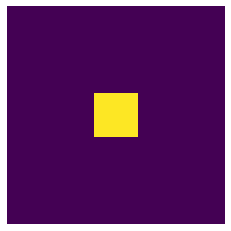

In [ ]:
# snowflake simulation 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

alpha = 1
beta = 0.5
gamma = 0.01
u = 0
v = 0
neighbors = []
is_center = False

width = 5
height = 5
center = (width // 2 , height // 2)
num_neighbors = 4

# width x height matrix to store cell objects
# indexed by cell coordinates
cells = np.empty((width, height), dtype=object)

class Cell: 
    def __init__(self,s,coor,is_receptive):
        self.u = 0 #water used in diffusion (this models the "diffusion view" of the cells, zero-ing out the receptive cells)
        self.v = 0 #water not used in diffusion (this models the "non diffusion view" of the cells, zero-ing out the nonreceptive cells)
        self.s = s #total water 
        self.coor = coor
        self.next_u = 0 
        self.next_v = 0
        self.is_receptive = is_receptive
    def get_s(self):
        return self.s
        
#get the neighbors for a specific coordinate
def get_neighbors(coor): 
    global cells
    x, y = coor
    
    # corner cases:
    if x >= width-1 and y >= height-1:
        neighbors = np.array([ cells[x-1,y], cells[x,y-1] ])
    elif x >= width-1 and y == 0:
        neighbors = np.array([ cells[x-1,y], cells[x,y+1] ])
    elif x == 0 and y >= height-1:
        neighbors = np.array([ cells[x+1,y], cells[x,y-1] ])
    elif x == 0 and y == 0:
        neighbors = np.array([ cells[x+1,y], cells[x,y+1] ])
    
    # in our case it is 4
    elif x >= width-1 and y > 0 and y < height-1:
        neighbors = np.array([ cells[x-1,y], cells[x,y-1], cells[x,y+1] ])
    elif x == 0 and y > 0 and y < height-1:
        neighbors = np.array([ cells[x+1,y], cells[x,y-1], cells[x,y+1] ])
    elif y >= height-1 and x > 0 and x < width-1:
        neighbors = np.array([ cells[x-1,y],  cells[x+1,y], cells[x,y-1] ])
    elif y == 0 and x > 0 and x < width-1:
        neighbors = np.array([ cells[x-1,y],  cells[x+1,y], cells[x,y+1] ])
    else:
        neighbors = np.array([ cells[x-1,y],  cells[x+1,y], cells[x,y-1], cells[x,y+1] ])
    return neighbors

# initialize grid
for i in range(width):
    for j in range(height):
        coordinate = (i,j)
        if coordinate == center: 
            is_center = True
            cells[i, j] = Cell(s=1, coor=coordinate, is_receptive=is_center)
        else:
            is_center = False
            cells[i, j] = Cell(s=beta, coor=coordinate, is_receptive=is_center)
            
# actual implementation
def one_iter():
    global cells
    # step 1: determine receptive sites
    for row in cells:
        for cell in row:
            if cell.is_receptive: # this is a receptive cell
                cell.u = 0
                cell.v = cell.s
                cell.next_v = cell.v + gamma
            else:
                cell.u = cell.s
                cell.v = 0
            
    # step 2: modify cell values
    for row in cells:
        for cell in row:   
            # determine the effects of diffusion    
            neighbors = get_neighbors(cell.coor)
            sum = 0
            for neighbor in neighbors:
                sum += neighbor.u
            u_avg = sum / (neighbors.size)
            # diffusion equation (laplace approximation)
            cell.next_u = cell.u + alpha / 2 * (u_avg - cell.u)
            
            # now update the cell
            cell.s = cell.next_u + cell.next_v
            if cell.s >= 0: # we are frozen, so we are receptive
                cell.is_receptive = True
    # last loop: must have all s values updated to determine new boundary cells
    for row in cells:
        for cell in row:
            if not cell.is_receptive:
                neighbors = get_neighbors(cell.coor)
                for neighbor in neighbors:
                    if neighbor.s >= 0: #we have at least one neighbor that is frozen
                        cell.is_receptive = True
                        break
def print_s():
    global cells
    print("[", end="")
    for row in cells:
        for cell in row:
            print(str(cell.get_s()) + " ", end="")
    print("]")

# plotting

print_s()
one_iter()
print_s()
one_iter()
print_s()